# CATE Estimation with Causal Effect Variational Autoencoder (CEVAE)

In this notebook, we demonstrate how to estimate **Conditional Average Treatment Effects
(CATE)** using a **Causal Effect Variational Autoencoder (CEVAE)** by implementing an example
from scratch in [NumPyro](https://num.pyro.ai/). This approach is particularly useful when we suspect
the presence of **unobserved confounders** that affect both treatment assignment and outcomes.

**Disclaimer**: I am not an expert in this specific approach, so please take all the results with a grain of salt and please do not hesitate to provide feedback.

## Motivation: Why CEVAE?

In observational studies, estimating causal effects is challenging because:

1. **Confounding**: Variables that affect both treatment and outcome can bias naive
   estimates
2. **Unobserved confounders**: Often, we cannot measure all confounding variables
3. **Selection bias**: Treatment assignment is typically not random

The CEVAE framework, introduced by
[Louizos et al. (2017)](https://arxiv.org/abs/1705.08821), addresses these challenges
by:

- Modeling a **latent confounder** $z$ that captures unobserved confounding
- Using **variational inference** to infer the posterior distribution of $z$
- Leveraging **neural networks** for flexible function approximation

This notebook works out the simulation example from the paper above, following the methodology from the
[ChiRho CEVAE tutorial](https://basisresearch.github.io/chirho/cevae.html), adapted
for pure NumPyro. The main difference is that we specify the model in the spirit of parameter recovery
(e.g. by specifying a smaller latent dimension) rather than trying to test the sensitivity with respect to the model specification.
As a matter of fact, we have also seen that the results can vary quite a lot depending on the model parameters. From the ChiRho tutorial:

> "Recent work [rissanen2021critical] has investigated the consequences of misspecifying components of the CEVAE model, concluding that its derived causal estimate are in fact sensitive to these detailed assumptions about the generative model. While some more restrictive settings may yield more robust identification results or bounds on causal effects (e.g. binary variables [kuroki2014measurement]), to the best of our knowledge little more is known about the nonparametric or semiparametric settings."

Therefore, for practical applications, we recommend to do a sensitivity analysis with respect to the model specification (e.g. neural network architecture, latent dimension, etc.), to assess the robustness of the CATE estimates.


**Remark [CEVAE in Pyro]**: [Pyro](https://pyro.ai/) has an implementation of the CEVAE model encapsulating the main components, see [Example: Causal Effect VAE](https://pyro.ai/examples/cevae.html).

## Key Concepts

### Potential Outcomes Framework

The **Conditional Average Treatment Effect (CATE)** for an individual with
characteristics captured by latent variable $z$ is defined as:

$$\text{CATE}(z) = \mathbb{E}[Y(1) - Y(0) \mid z] = P(Y=1 \mid \text{do}(T=1), z) -
P(Y=1 \mid \text{do}(T=0), z)$$

where:
- $Y(1)$ is the **potential outcome** under treatment ($T=1$)
- $Y(0)$ is the **potential outcome** under control ($T=0$)
- $\text{do}(T=t)$ denotes an **intervention** setting treatment to value $t$

The fundamental problem of causal inference is that we only observe one potential
outcome per individual—the one corresponding to their actual treatment.



### The CEVAE Graphical Model

The CEVAE assumes the following generative process:

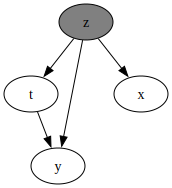

In [1]:
import graphviz as gr

g = gr.Digraph()
g.node("z", style="filled", fillcolor="gray")
g.edge("t", "y")
g.edge("z", "y")
g.edge("z", "t")
g.edge("z", "x")

g

Where:
- $z$: Latent confounder (unobserved)
- $x$: Observed covariates (proxy for $z$)
- $t$: Treatment assignment
- $y$: Outcome

The key insight is that while $z$ is unobserved, we can **infer** it from the observed
variables using variational inference.

## Prepare Notebook

In [2]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float32, Int32, UInt32
from numpyro.contrib.module import nnx_module
from numpyro.handlers import condition, do, seed, trace
from numpyro.infer import SVI, Predictive, Trace_ELBO
from pydantic import BaseModel

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Data Generating Process (DGP)

We simulate data with a **known** data generating process so we can validate our
CATE estimates. This is crucial for understanding whether our method works correctly.
This data generating process is the same as the one used in the original CEVAE paper
and the ChiRho tutorial.

### The True DGP

Our synthetic data follows this generative process:

1. **Latent confounder**: $z \sim \text{Bernoulli}(0.5)$
   - Binary latent variable that we **cannot observe** in practice

2. **Covariates**: $x_i \mid z \sim \text{Normal}(z \cdot \text{z\_gap},
   \sigma_z)$ for $i = 1, \ldots, d$
   - Covariates are **proxies** for the latent confounder
   - Different means and variances depending on $z$

3. **Treatment**: $t \mid z \sim \text{Bernoulli}(0.75z + 0.25(1-z))$
   - Treatment probability depends on $z$ (confounding!)
   - When $z=1$: $P(T=1) = 0.75$
   - When $z=0$: $P(T=1) = 0.25$

4. **Outcome**: $y \mid z, t \sim \text{Bernoulli}(\text{logits} =
   \text{y\_gap} \cdot (z + 2(2t - 1)))$
   - Outcome depends on **both** $z$ and $t$
   - The treatment effect varies with $z$

### True CATE Calculation

From the DGP, we can analytically compute the true CATE:

$$\text{CATE}(z) = \text{sigmoid}(\text{y\_gap} \cdot (z + 2)) -
\text{sigmoid}(\text{y\_gap} \cdot (z - 2))$$

With `y_gap = 3.0`:
- For $z=0$: $\text{CATE} = \text{sigmoid}(6) - \text{sigmoid}(-6) \approx 0.995$
- For $z=1$: $\text{CATE} = \text{sigmoid}(9) - \text{sigmoid}(-3) \approx 0.952$

Let's express this data generating process as a NumPyro model:

In [3]:
class DGPParams(BaseModel):
    num_train: int = 10_000
    num_test: int = 2_000
    feature_dim: int = 10
    z_gap: float = 1.0
    y_gap: float = 3.0


def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[Array, Array, Array, Array]:
    """Generate synthetic data with latent confounder.

    Parameters
    ----------
    num_data : int
        Number of observations to generate
    feature_dim : int
        Dimension of the covariate vector x
    z_gap : float
        Controls separation between z=0 and z=1 in covariate space
    y_gap : float
        Controls the strength of treatment effect

    Returns
    -------
    x : Array of shape (num_data, feature_dim)
        Observed covariates
    t : Array of shape (num_data,)
        Binary treatment assignment
    y : Array of shape (num_data,)
        Binary outcome
    z : Array of shape (num_data,)
        Latent confounder (for evaluation only)
    """
    with numpyro.plate("num_data", num_data):
        # Latent confounder - THIS IS UNOBSERVED IN PRACTICE
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        # Covariates depend on z (proxies for the confounder)
        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z))).T

        # Treatment depends on z (confounding!)
        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))

        # Outcome depends on BOTH z and t
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        return x, t, y, z

We can now generate the training and test data:

In [4]:
dgp_params = DGPParams()

# Generate training data (z is discarded - we pretend we can't observe it)
rng_key, rng_subkey = random.split(rng_key)
x_train, t_train, y_train, z_train = trace(seed(generate_data, rng_subkey))(
    num_data=dgp_params.num_train,
    feature_dim=dgp_params.feature_dim,
    z_gap=dgp_params.z_gap,
    y_gap=dgp_params.y_gap,
)

# Generate test data (keep z for evaluation purposes)
rng_key, rng_subkey = random.split(rng_key)
x_test, t_test, y_test, z_test = trace(seed(generate_data, rng_subkey))(
    num_data=dgp_params.num_test,
    feature_dim=dgp_params.feature_dim,
    z_gap=dgp_params.z_gap,
    y_gap=dgp_params.y_gap,
)

# Compute TRUE CATE for evaluation (we know the DGP!)
train_true_cate_probs = jax.nn.sigmoid(
    dgp_params.y_gap * (z_train + 2)
) - jax.nn.sigmoid(dgp_params.y_gap * (z_train - 2))

test_true_cate_probs = jax.nn.sigmoid(dgp_params.y_gap * (z_test + 2)) - jax.nn.sigmoid(
    dgp_params.y_gap * (z_test - 2)
)

print(f"Train True CATE (z=0): {train_true_cate_probs[z_train == 0].mean():.4f}")
print(f"Train True CATE (z=1): {train_true_cate_probs[z_train == 1].mean():.4f}")
print("-" * 30)
print(f"Test True CATE (z=0): {test_true_cate_probs[z_test == 0].mean():.4f}")
print(f"Test True CATE (z=1): {test_true_cate_probs[z_test == 1].mean():.4f}")

Train True CATE (z=0): 0.9951
Train True CATE (z=1): 0.9524
------------------------------
Test True CATE (z=0): 0.9951
Test True CATE (z=1): 0.9524


It is of course not surprising that:

- The CATE depends on $z$.
- The CATE is the same for the train and test set in this synthetic example.

## Why Naive Approaches Fail?

Before diving into CEVAE, let's understand why simpler approaches fail for CATE
estimation with unobserved confounders.

### Naive Approach 1: Simple Difference in Means

A naive estimate would be:
$$\widehat{\text{ATE}}_{\text{naive}} = \text{E}[Y \mid T=1] - \text{E}[Y \mid T=0]$$

This is **biased** because treatment assignment is confounded by $z$. People with
$z=1$ are more likely to receive treatment AND have different baseline outcomes.

We can now compute the naive ATE estimates and compare them to the true ATE:

In [5]:
# Naive ATE estimate (biased due to confounding)
train_naive_ate = y_train[t_train == 1].mean() - y_train[t_train == 0].mean()
train_true_ate = train_true_cate_probs.mean()

print(f"Naive ATE estimate (train): {train_naive_ate:.4f}")
print(f"True ATE (train): {train_true_ate:.4f}")
print(f"Bias (train): {train_naive_ate - train_true_ate:.4f}")

print("-" * 40)

test_naive_ate = y_test[t_test == 1].mean() - y_test[t_test == 0].mean()
test_true_ate = test_true_cate_probs.mean()

print(f"Naive ATE estimate (test): {test_naive_ate:.4f}")
print(f"True ATE (test): {test_true_ate:.4f}")
print(f"Bias (test): {test_naive_ate - test_true_ate:.4f}")

Naive ATE estimate (train): 0.9873
True ATE (train): 0.9738
Bias (train): 0.0136
----------------------------------------
Naive ATE estimate (test): 0.9940
True ATE (test): 0.9738
Bias (test): 0.0202


The strategy in CEVAE is to use a Bayesian `model`, to account for the unobserved confounder, to estimate the CATE (and of course with a variational autoencoder) by generating counterfactuals using the [`do`](https://num.pyro.ai/en/stable/handlers.html#do) operator. It is, in essence, the same strategy as in the blog post ["Introduction to Causal Inference with PPLs"](https://juanitorduz.github.io/intro_causal_inference_ppl_pymc/). We will see how to do this in NumPyro in the next sections.

## Model Specification

Ok! Now that we know that we need some work to account for the unobserved confounder, let's see how to do this in NumPyro with the CEVAE approach.
The main steps are as follows:

**Modeling Strategy**:
1. Learn a latent variable $z$ that captures the confounding structure.
2. Use a **generative model** (decoder) that generates $x$, $t$, and $y$ from $z$
3. Use an **inference model** (encoder) that infers $z$ from observed data
4. Crucially, use **separate outcome networks** for each treatment level to avoid
   the network collapsing to a constant prediction
5. At test time, infer $z$ from covariates $x$ only, then compute counterfactual
   outcomes under both treatments using the same $z$ sample

For the generative models, we will use simple neural network architectures.

If this feels a bit abstract, it's ok! That is the reason why we are going to implement this from scratch.

### Neural Network Components

We use [Flax NNX](https://flax.readthedocs.io/en/latest/nnx/index.html) for defining
neural network modules that integrate with NumPyro via [`nnx_module`](https://num.pyro.ai/en/0.19.0/primitives.html#nnx-module).

#### Architecture Overview

Now that we have stated the overall strategy, we can look into the architecture in detail. Our CEVAE consists of:

1. **Decoder networks** (generative model):
   - `x_nn`: $z \to (\mu_x, \sigma_x)$ - generates covariates from latent
   - `t_nn`: $z \to \text{logits}_t$ - generates treatment probability
   - `y_nn_t0`, `y_nn_t1`: $z \to \text{logits}_y$ - generates outcome probability

2. **Encoder networks** (inference/guide):
   - Training encoder: $(x, t, y) \to (\mu_z, \sigma_z)$ - infers $z$ from all
     observed data
   - Test encoder: $x \to (\mu_z, \sigma_z)$ - infers $z$ from covariates only


In order to make everything tangible, let's start with the implementation.

We start by defining a helper class to store the model parameters:

In [6]:
class ModelParams(BaseModel):
    feature_dim: int = 10
    latent_dim: int = 1
    hidden_dim: int = 50
    num_layers: int = 2

    @property
    def hidden_layers(self) -> list[int]:
        return [self.hidden_dim] * self.num_layers

Now we are ready to define the neural network modules:

In [7]:
class FullyConnected(nnx.Module):
    """Base fully connected network with ELU activations."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [din, *hidden_layers, dout]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: Array) -> Array:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return x


class DiagNormalNet(FullyConnected):
    """Network outputting mean and scale for a diagonal normal distribution."""

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        super().__init__(din, 2 * dout, hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        loc, scale = jnp.split(super().__call__(x), 2, axis=-1)
        return loc, jax.nn.softplus(scale)


class BernoulliNet(FullyConnected):
    """Network outputting logits for a Bernoulli distribution."""

    def __call__(self, x: Array) -> Array:
        return jax.lax.clamp(-10.0, super().__call__(x), 10.0)


class Encoder(nnx.Module):
    """Encoder for amortized variational inference q(z|inputs).

    Maps observed data to the parameters of the approximate posterior
    distribution over the latent confounder z.
    """

    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_layers: list[int],
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.layers = nnx.List([])
        layer_dims = [input_dim, *hidden_layers]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

        final_dim = hidden_layers[-1] if hidden_layers else input_dim
        self.f_loc = nnx.Linear(final_dim, latent_dim, rngs=rngs)
        self.f_scale = nnx.Linear(final_dim, latent_dim, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return self.f_loc(x), jax.nn.softplus(self.f_scale(x)) + 1e-6

We now initialize all the neural network modules:

In [8]:
# Initialize all neural network modules with default values.
model_params = ModelParams()

# We generate random keys for the neural network initialization.
rng_key, *subkeys = random.split(rng_key, 7)

# Decoder networks (generative model)
x_nn_module = DiagNormalNet(
    din=model_params.latent_dim,
    dout=model_params.feature_dim,
    hidden_layers=model_params.hidden_layers,
    rngs=nnx.Rngs(subkeys[0]),
)

t_nn_module = BernoulliNet(
    din=model_params.latent_dim,
    dout=1,
    hidden_layers=model_params.hidden_layers,
    rngs=nnx.Rngs(subkeys[1]),
)

# We use simple linear layers for the outcome networks.
y_nn_t0_module = nnx.Linear(
    in_features=model_params.latent_dim,
    out_features=1,
    rngs=nnx.Rngs(subkeys[2]),
)
y_nn_t1_module = nnx.Linear(
    in_features=model_params.latent_dim,
    out_features=1,
    rngs=nnx.Rngs(subkeys[3]),
)

# Training encoder: q(z|x,t,y) - uses all observed data
encoder_module = Encoder(
    # The +2 accounts for the treatment and outcome variables
    input_dim=model_params.feature_dim + 2,
    latent_dim=model_params.latent_dim,
    hidden_layers=model_params.hidden_layers,
    rngs=nnx.Rngs(subkeys[4]),
)

# Test-time encoder: q(z|x) - infers z from covariates only
test_encoder_module = Encoder(
    input_dim=model_params.feature_dim,
    latent_dim=model_params.latent_dim,
    hidden_layers=model_params.hidden_layers,
    rngs=nnx.Rngs(subkeys[5]),
)

With these components at hand, we can now define the generative model:

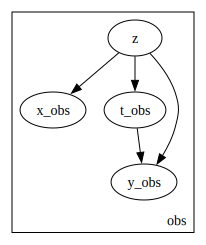

In [9]:
# Even though we are not using all the variables in the model
# signature, we need this signature to match the corresponding guide.
def model(
    x: Float32[Array, "n d"],
    t: Int32[Array, " n"],
    y: Int32[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Generative model: p(x, t, y | z) p(z).

    This defines the causal structure where the latent confounder z
    affects covariates x, treatment t, and outcome y.
    """
    num_data = t.shape[0]

    # Register neural network modules
    x_nn = nnx_module("x_nn", x_nn_module)
    t_nn = nnx_module("t_nn", t_nn_module)
    y_nn_t0 = nnx_module("y_nn_t0", y_nn_t0_module)
    y_nn_t1 = nnx_module("y_nn_t1", y_nn_t1_module)

    with numpyro.plate("obs", num_data):
        # Prior on latent confounder
        z = numpyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))

        # Covariates depend on z
        x_loc, x_scale = x_nn(z)
        numpyro.sample("x_obs", dist.Normal(x_loc, x_scale).to_event(1))

        # Treatment depends on z
        t_logits = t_nn(z).squeeze(-1)
        t_obs = numpyro.sample("t_obs", dist.Bernoulli(logits=t_logits))

        # Outcome depends on z and t
        # Use the appropriate network based on treatment value
        y_logits_0 = y_nn_t0(z).squeeze(-1)
        y_logits_1 = y_nn_t1(z).squeeze(-1)
        y_logits = jnp.where(t_obs == 1, y_logits_1, y_logits_0)
        numpyro.sample("y_obs", dist.Bernoulli(logits=y_logits))


# Visualize the model
numpyro.render_model(
    model,
    model_kwargs={
        "x": x_train,
        "t": t_train,
        "y": y_train,
        "latent_dim": model_params.latent_dim,
    },
)

## Model and Guide Definitions

Next, we focus on the training process. We are going to use stochastic variational inference (SVI) to maximize the evidence lower bound (ELBO).
For this, we need to define the guide, that is the variational distribution over the latent variables. If you are not familiar with SVI, please see the previous blog post [PyData Berlin 2025: Introduction to Stochastic Variational Inference with NumPyro](https://juanitorduz.github.io/intro_svi/).

### The Training Guide

During training, we use a guide (variational distribution) that conditions on
**all observed data**: $q(z \mid x, t, y)$.

This is the standard CEVAE approach—using all available information to get the
best possible inference of $z$.

### The Test-Time Guide

At test time, we need to estimate CATE for new individuals where we want to
predict **both** potential outcomes. We cannot use $t$ and $y$ in the guide because:

1. We want to intervene on $t$ (set it to $0$ and $1$)
2. We don't know what $y$ would be under the counterfactual treatment

Therefore, we train a **separate encoder** that infers $z$ from $x$ alone:
$q(z \mid x)$.

This two-stage approach follows the [ChiRho CEVAE tutorial](https://basisresearch.github.io/chirho/cevae.html).

Let's implement both of these guides using the encoder modules we defined earlier:

In [10]:
def guide(
    x: Float32[Array, "n d"],
    t: Int32[Array, " n"],
    y: Int32[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Training guide: q(z | x, t, y).

    Uses all observed data to infer the latent confounder.
    This provides the best possible inference during training.
    """
    num_data = x.shape[0]
    encoder = nnx_module("encoder", encoder_module)

    # Concatenate all observed data as encoder input
    encoder_input = jnp.concatenate(
        [x, t[:, None].astype(jnp.float32), y[:, None].astype(jnp.float32)], axis=-1
    )
    z_loc, z_scale = encoder(encoder_input)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


def test_guide(
    x: Float32[Array, "n d"],
    t: Int32[Array, " n"],
    y: Int32[Array, " n"] | None = None,
    latent_dim: int = 1,
) -> None:
    """Test-time guide: q(z | x).

    Infers z from covariates only. This is necessary for CATE estimation
    because we need to predict outcomes under BOTH treatment values,
    so we cannot condition on the observed t and y.
    """
    num_data = x.shape[0]
    test_encoder = nnx_module("test_encoder", test_encoder_module)

    # Only use covariates x for inference
    z_loc, z_scale = test_encoder(x)

    with numpyro.plate("obs", num_data):
        numpyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

## Stage 1: Train the Model

Now that we have all the ingredients ready, we can start the inference process.

Before training, we need to condition the model on the training data. The
[`condition`](https://num.pyro.ai/en/0.19.0/handlers.html#condition) handler fixes the observed variables to their data values, allowing
the model to learn the relationship between the latent $z$ and the observations.

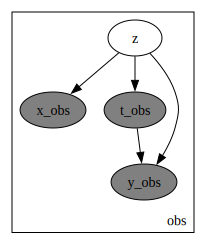

In [11]:
# Condition model on training data
conditioned_model = condition(
    model, data={"x_obs": x_train, "t_obs": t_train, "y_obs": y_train}
)

numpyro.render_model(
    conditioned_model,
    model_kwargs={
        "x": x_train,
        "t": t_train,
        "y": y_train,
        "latent_dim": model_params.latent_dim,
    },
)

Now we can train the model:

100%|██████████| 20000/20000 [01:30<00:00, 221.15it/s, init loss: 2540562.0000, avg. loss [19001-20000]: 287445.3438]


CPU times: user 6min 40s, sys: 2min 3s, total: 8min 43s
Wall time: 1min 31s


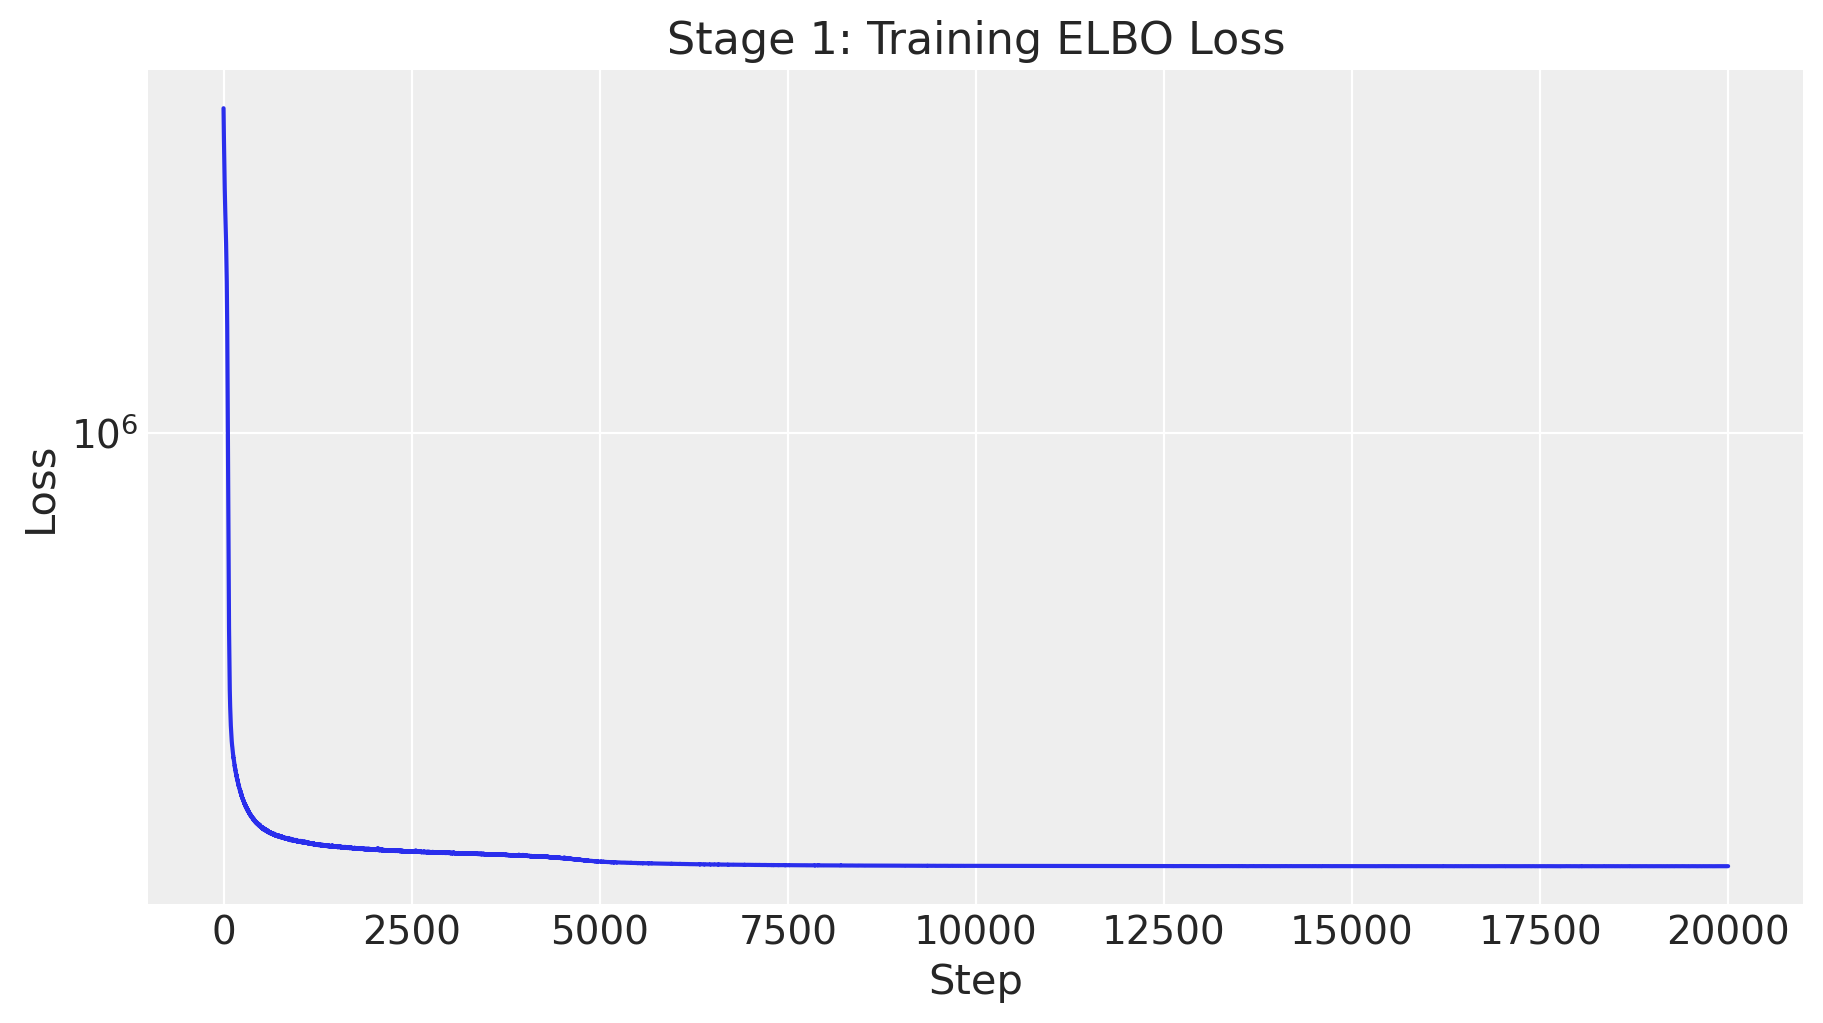

In [12]:
%%time

num_steps = 20_000

# One-cycle learning rate schedule for stable training
scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.0005,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)

optimizer = optax.adam(learning_rate=scheduler)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(
    rng_subkey,
    num_steps,
    x=x_train,
    t=t_train,
    y=y_train,
    latent_dim=model_params.latent_dim,
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(svi_result.losses)
ax.set(
    title="Stage 1: Training ELBO Loss",
    xlabel="Step",
    ylabel="Loss",
    yscale="log",
);

The ELBO loss looks good, so we can proceed to the next stage.

## Stage 2: Test-Time Encoder Training

This is a **critical step**! At test time, we need to infer $z$ from $x$ alone (not $t$ and $y$) because:

1. **For CATE estimation**: We want to predict outcomes under **both** treatments,
   so we cannot condition on the observed treatment
2. **For counterfactual reasoning**: We need the same $z$ for both potential
   outcomes

We train a new encoder $q(z \mid x)$ while **keeping the decoder networks fixed**.
This ensures the test encoder learns to produce $z$ values that are consistent
with the learned generative model.

100%|██████████| 20000/20000 [00:42<00:00, 475.43it/s, init loss: 80796.7656, avg. loss [19001-20000]: 57652.3477]


CPU times: user 1min 31s, sys: 31.5 s, total: 2min 2s
Wall time: 43.3 s


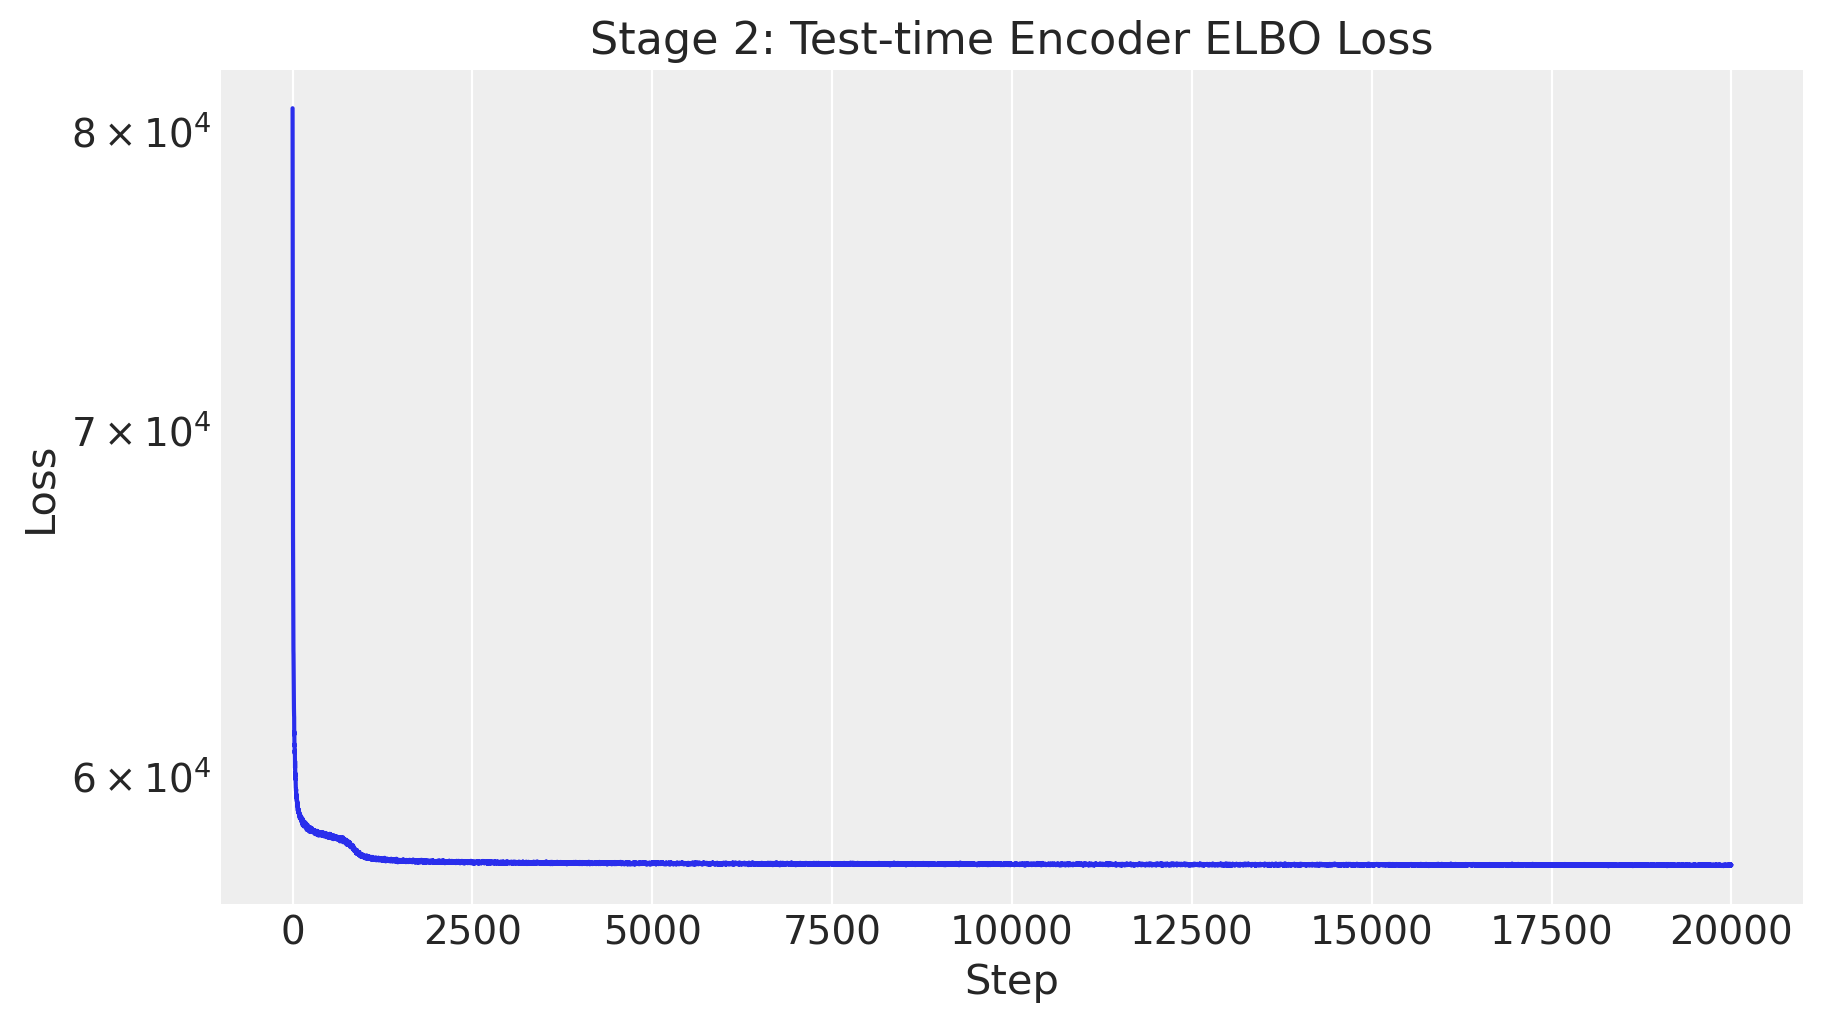

In [13]:
%%time

params = svi_result.params

# Condition on test data for the second stage
test_conditioned_model = condition(
    model, data={"x_obs": x_test, "t_obs": t_test, "y_obs": y_test}
)

test_num_steps = 20_000
test_scheduler = optax.linear_onecycle_schedule(
    transition_steps=test_num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=5,
)
test_optimizer = optax.adam(learning_rate=test_scheduler)
test_svi = SVI(test_conditioned_model, test_guide, test_optimizer, loss=Trace_ELBO())

rng_key, rng_subkey = random.split(rng_key)
test_svi_result = test_svi.run(
    rng_subkey,
    test_num_steps,
    x=x_test,
    t=t_test,
    y=y_test,
    latent_dim=model_params.latent_dim,
    # Initialize with trained parameters (keeps decoders fixed)
    init_params=params.copy(),
)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(test_svi_result.losses)
ax.set(
    title="Stage 2: Test-time Encoder ELBO Loss",
    xlabel="Step",
    ylabel="Loss",
    yscale="log",
);

As above, the loss looks good.

## CATE Estimation: The Correct Approach

Now that we have learned the parameters from the data, we can estimate CATE using the trained model. The key observation is that we must
use the **same** $z$ samples when computing both potential outcomes.

### The Algorithm

1. **Sample $z$ from the test-time guide**: $z \sim q(z \mid x)$
   - This infers the latent confounder from covariates only

2. **Compute $Y(0)$**: Use `condition(model, {"z": z_sample})` + `do({"t_obs": 0})`
   - Fix $z$ to the sampled value
   - Intervene to set treatment to 0

3. **Compute $Y(1)$**: Use `condition(model, {"z": z_sample})` + `do({"t_obs": 1})`
   - Use the **same** $z$ sample
   - Intervene to set treatment to 1

4. **CATE**: $\widehat{\text{CATE}} = Y(1) - Y(0)$

### NumPyro Handlers

Recall from above, we use two NumPyro handlers:

- [`condition`](https://num.pyro.ai/en/0.19.0/handlers.html#condition): Fixes a random variable to a specific value (for $z$).
- [`do`](https://num.pyro.ai/en/0.19.0/handlers.html#do): Implements a causal intervention (for $t$).

The combination `do(condition(model, {"z": z}), {"t_obs": t})` gives us the
interventional distribution $p(y \mid \text{do}(T=t), z)$.

Let's see how we can do this in practice:

In [14]:
test_params = test_svi_result.params
num_samples = 4_000

# Step 1: Sample z from the test-time guide (infers z from x only)
z_predictive_test = Predictive(
    model=model,
    guide=test_guide,
    params=test_params,
    num_samples=num_samples,
    return_sites=["z"],
)

rng_key, rng_subkey = random.split(rng_key)
z_samples_test = z_predictive_test(
    rng_subkey, x=x_test, t=t_test, y=y_test, latent_dim=model_params.latent_dim
)["z"]  # Shape: (num_samples, num_data, latent_dim)


# Step 2: Compute potential outcomes using the SAME z samples
@jax.jit
def compute_y_obs_under_intervention(
    rng_key: UInt32[Array, "2"],
    z_sample: Float32[Array, "n latent_dim"],
    t_value: Int32[Array, ""],
) -> Int32[Array, " n"]:
    """Compute y_obs under do(t_obs=t_value) with fixed z.

    This is the correct way to compute counterfactuals:
    1. condition on z to fix the latent confounder
    2. do() to intervene on treatment
    3. Sample from the resulting distribution
    """
    # Intervene on t_obs AND condition on z
    intervened_model = do(
        condition(model, data={"z": z_sample}),
        data={"t_obs": jnp.full(dgp_params.num_test, t_value)},
    )

    predictive = Predictive(
        model=intervened_model,
        guide=test_guide,
        params=test_params,
        num_samples=1,
        return_sites=["y_obs"],
    )

    return predictive(
        rng_key, x=x_test, t=t_test, y=y_test, latent_dim=model_params.latent_dim
    )["y_obs"].squeeze(0)


rng_key, rng_subkey = random.split(rng_key)
rng_keys = random.split(rng_subkey, num_samples * 2)

# Y(0): Outcome under control (t=0)
test_y_obs_t0_samples = jax.vmap(
    lambda z, key: compute_y_obs_under_intervention(key, z, 0)
)(z_samples_test, rng_keys[:num_samples])

# Y(1): Outcome under treatment (t=1)
test_y_obs_t1_samples = jax.vmap(
    lambda z, key: compute_y_obs_under_intervention(key, z, 1)
)(z_samples_test, rng_keys[num_samples:])

# CATE = E[Y(1) - Y(0) | z]
# Since y_obs is binary, the mean across samples gives P(Y=1|do(T), z)
test_cate_samples = (
    test_y_obs_t1_samples - test_y_obs_t0_samples
)  # Shape: (num_samples, num_data)

# Take the mean across samples to get the estimated CATEs per individual
test_est_cates = test_cate_samples.mean(axis=0)  # Shape: (num_data,)

## Results

Let's compare our CATE estimates to the true values from the DGP.

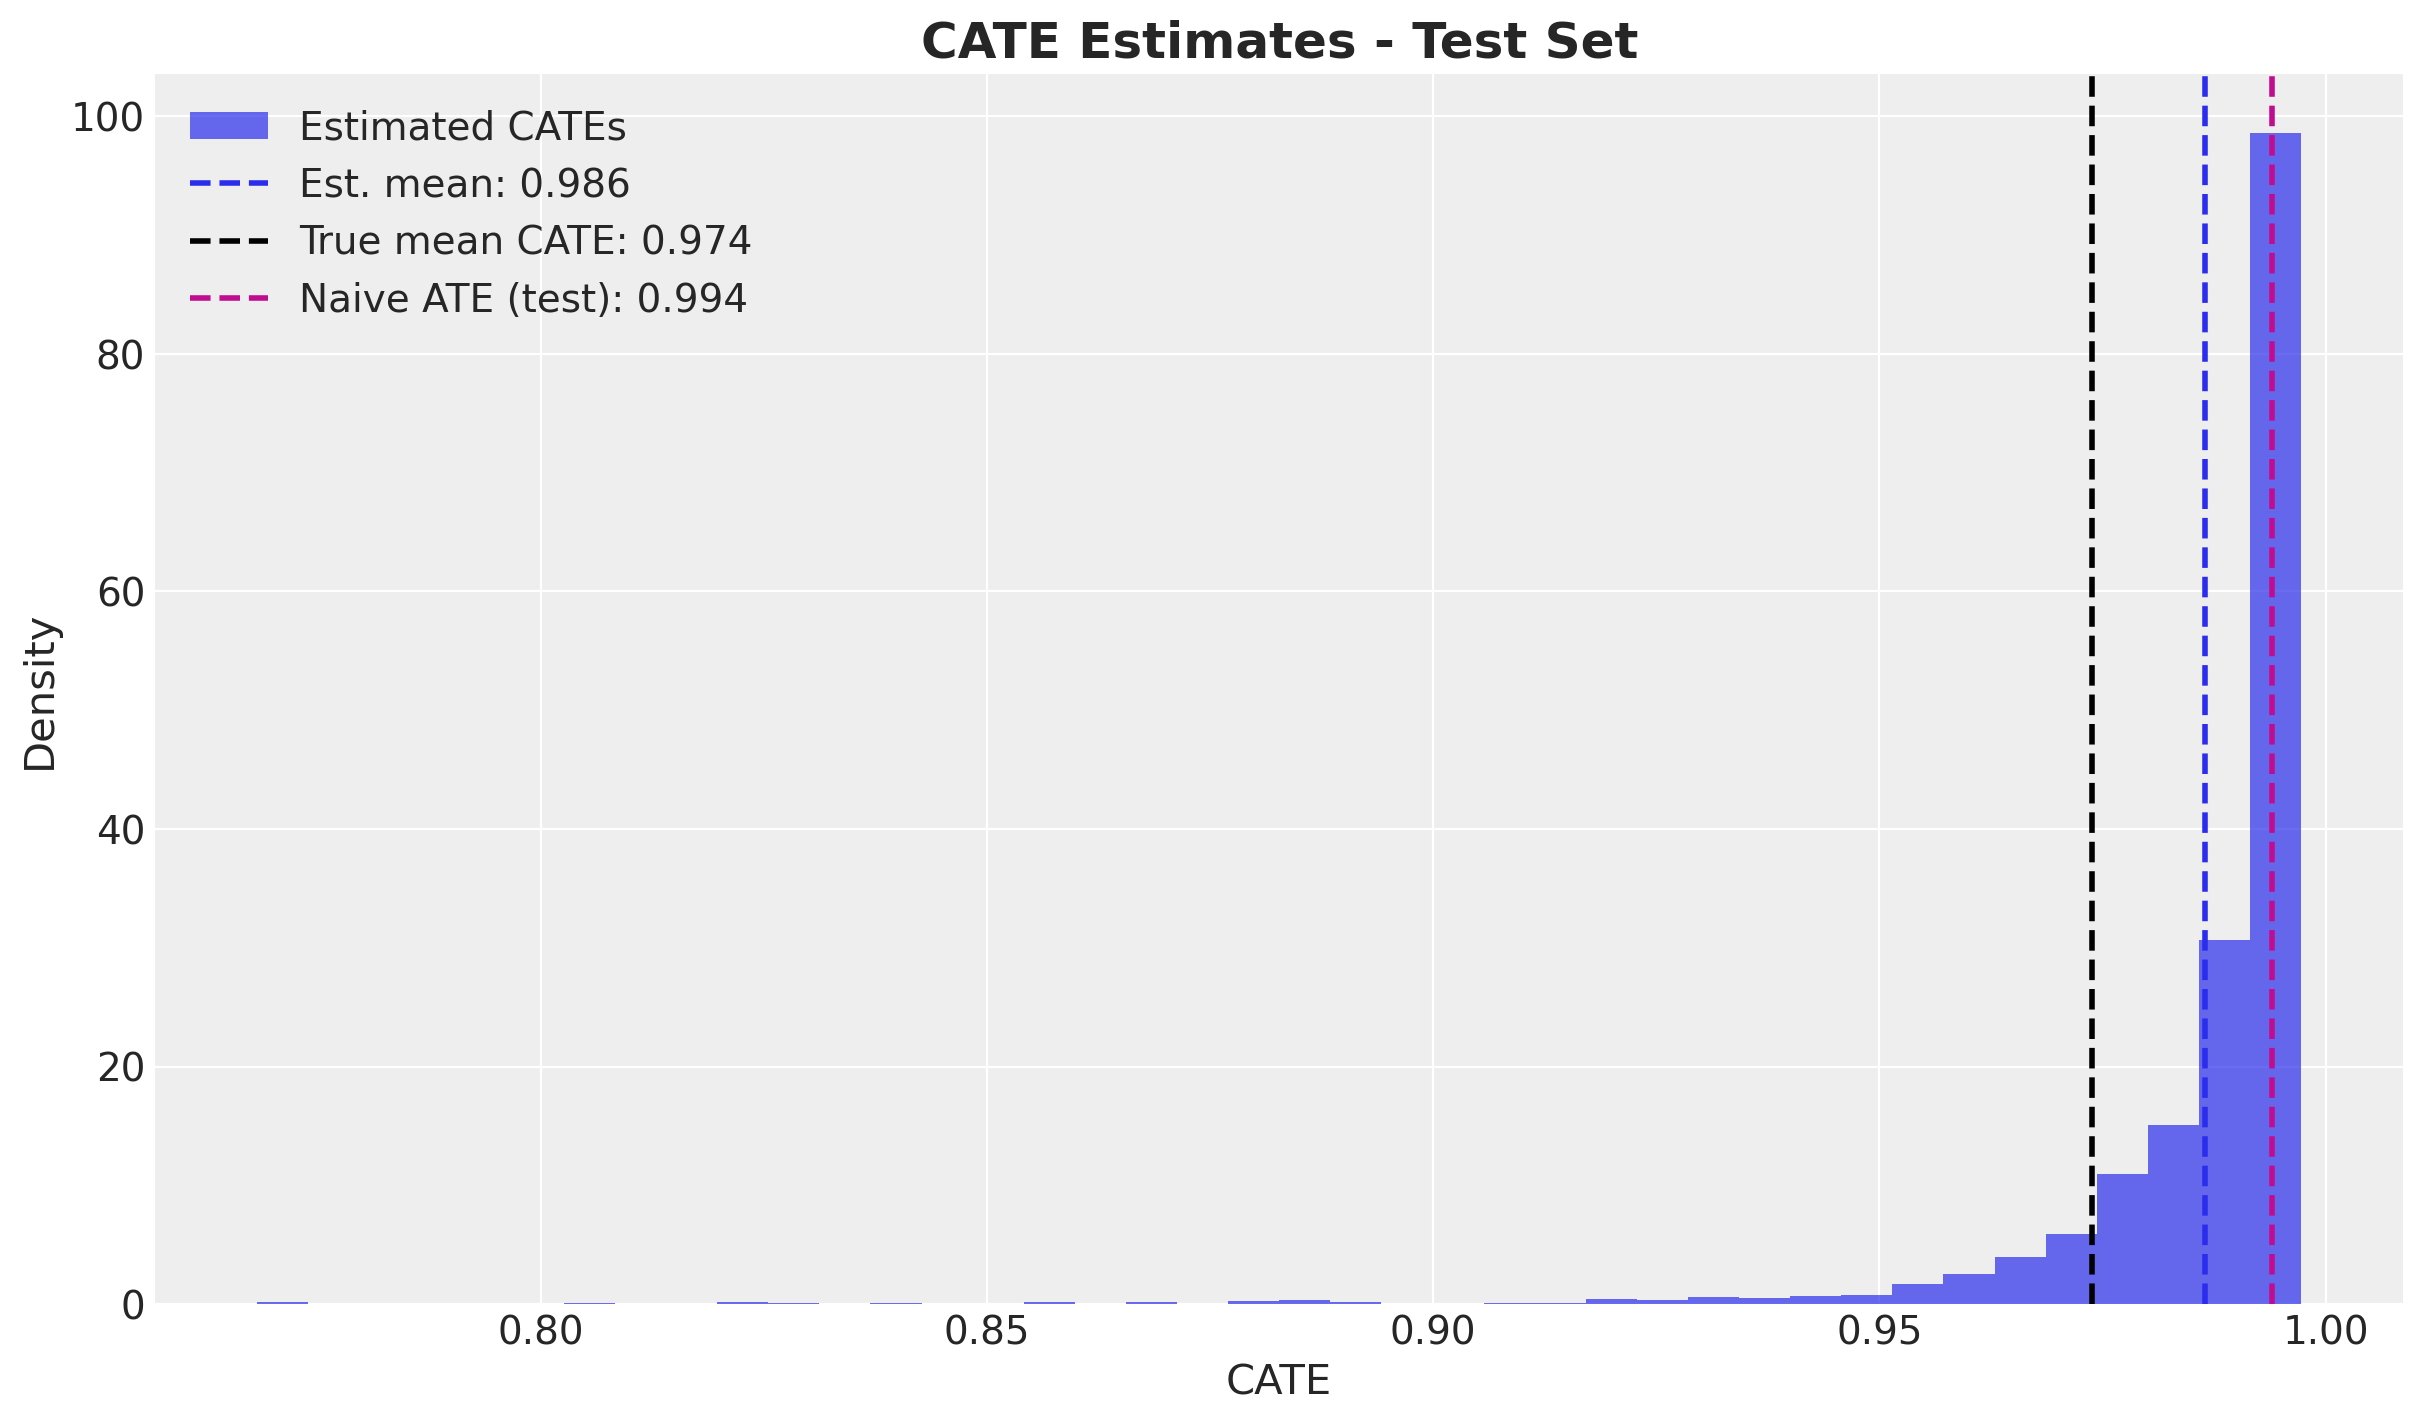

In [15]:
fig, ax = plt.subplots()
ax.hist(
    test_est_cates,
    bins=40,
    color="C0",
    label="Estimated CATEs",
    density=True,
    alpha=0.7,
)
ax.axvline(
    test_est_cates.mean(),
    color="C0",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {test_est_cates.mean():.3f}",
)
ax.axvline(
    test_true_ate,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True mean CATE: {test_true_ate:.3f}",
)
ax.axvline(
    test_naive_ate,
    color="C3",
    linestyle="--",
    linewidth=2,
    label=f"Naive ATE (test): {test_naive_ate:.3f}",
)
ax.legend()
ax.set(xlabel="CATE", ylabel="Density")
ax.set_title("CATE Estimates - Test Set", fontsize=18, fontweight="bold");

The histogram of estimated CATEs contains the true average CATE and is indeed closer to the true CATE than the naive estimate.

We can also separate the estimates by the true $z$ value to see if the model
can recover the CATEs for different values of the latent confounder.


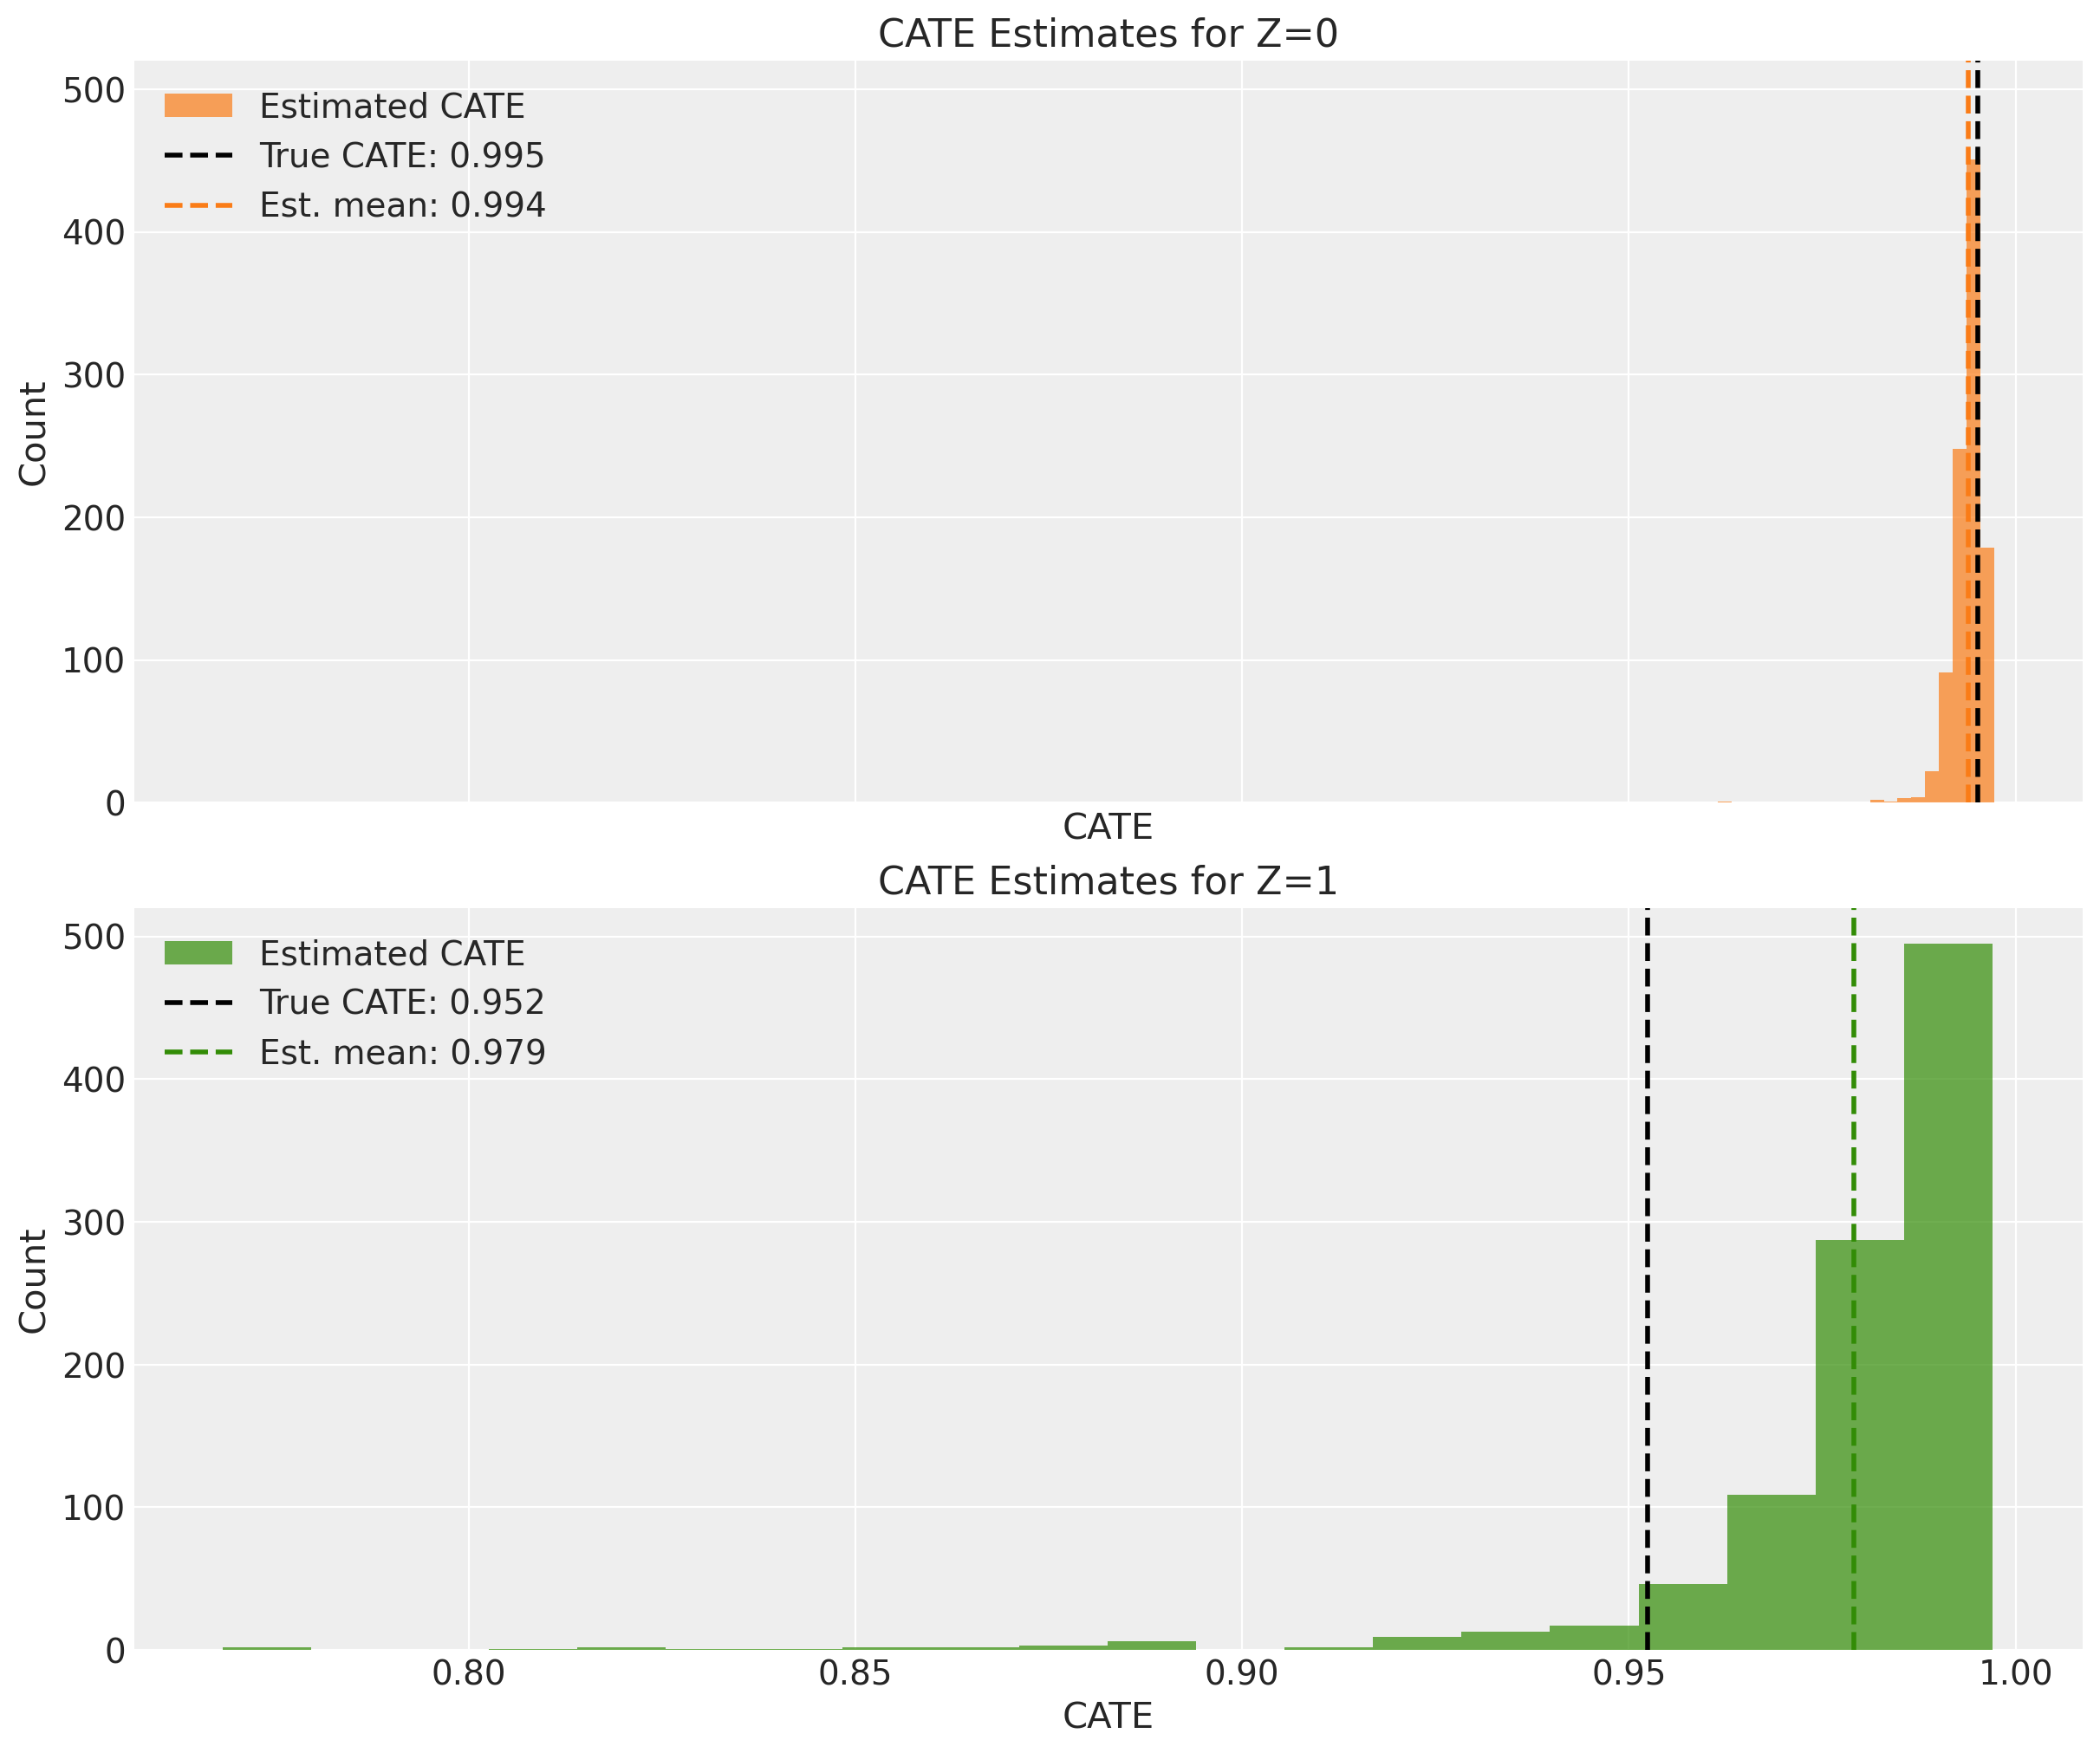

In [16]:
# Separate estimates by true z value (for evaluation)
test_cates_z0 = test_est_cates[z_test == 0]
test_cates_z1 = test_est_cates[z_test == 1]
true_cate_z0 = test_true_cate_probs[z_test == 0]
true_cate_z1 = test_true_cate_probs[z_test == 1]

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].hist(test_cates_z0, bins=20, color="C1", alpha=0.7, label="Estimated CATE")
ax[0].axvline(
    true_cate_z0.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z0.mean().item():.3f}",
)
ax[0].axvline(
    test_cates_z0.mean(),
    color="C1",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {test_cates_z0.mean():.3f}",
)
ax[0].legend()
ax[0].set(title="CATE Estimates for Z=0", xlabel="CATE", ylabel="Count")

ax[1].hist(test_cates_z1, bins=20, color="C2", alpha=0.7, label="Estimated CATE")
ax[1].axvline(
    true_cate_z1.mean().item(),
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"True CATE: {true_cate_z1.mean().item():.3f}",
)
ax[1].axvline(
    test_cates_z1.mean(),
    color="C2",
    linestyle="--",
    linewidth=2,
    label=f"Est. mean: {test_cates_z1.mean():.3f}",
)
ax[1].legend()
ax[1].set(title="CATE Estimates for Z=1", xlabel="CATE", ylabel="Count");

For $z=0$ the model is able to recover the true CATE mean, but for $z=1$ the
model overestimates the CATEs a bit.

## Summary and Key Takeaways

We have seen an explicit implementation of the CEVAE approach to estimate the CATEs for a synthetic dataset. The main takeaways are:

1. **CEVAE can recover CATE** even with unobserved confounders, by inferring
   the latent confounder from observed proxies (covariates).

2. **Architecture matters**: Using separate linear networks for each treatment
   level prevents the model from ignoring the latent variable.

3. **Two-stage inference**: Train the main model first, then train a test-time
   encoder that infers $z$ from $x$ alone.

4. **Correct counterfactual computation**: Use `condition` + `do` to ensure the
   same $z$ is used for both potential outcomes.

5. Results are sensitive to the choice of architecture, so it is important to
   carefully design the model and do proper sensitivity analysis.

### References

- [Louizos et al. (2017) - Causal Effect Inference with Deep Latent-Variable
  Models](https://arxiv.org/abs/1705.08821)
- [ChiRho CEVAE Tutorial](https://basisresearch.github.io/chirho/cevae.html)
- [NumPyro Documentation](https://num.pyro.ai/)